# Using the hybrid database with BACI price info.

This note book is an illustration of how BACI price data can be used in combinatoin with the $C_\mathrm{u}$ matrix to hybridise ecoinvent 3.5. 

In [1]:
import pandas as pd
import numpy as np

import sys
# your path to pylacio
sys.path.append('/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/')
import pylcaio

import gzip
import pickle
import pandas as pd


import matplotlib.pyplot as plt
import os

import time
import seaborn as sns
from matplotlib import rc 
import matplotlib.cm as colormaps
import feather
import scipy
from pypardiso import spsolve, factorized

import scipy.stats as stats
sys.path.append(os.path.realpath('../'))
from price_variance_MC import generate_price_vector, do_price_MC


/home/jakobs/anaconda3/envs/pylcaio_paradiso/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib import rc
# sns.set()
rc('font',**{'family':'DejaVu Sans', 'size':18})                                            
rc('text', usetex=True)      

## First load in the data:

- ecoinvent, exiobase and the Cu matrix are stored in one pickle file:
- The price data is stored as a feather file. 

In [3]:
# Define double counting correction strategy and year
double_counting = 'STAM'  # 'STAM' or 'binary'
year = 2012
# read in pickle
analysis_object = pylcaio.Analysis('/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_{}/hybrid_system_{}.pickle'.format(year, double_counting))

### Read in correct characterisation matrix for EXIOBASE 3.6

Because we use a different version of EXIOBASE than was used in pylcaio, we need to read it in seperately and use it here. We will use the GWP100 indicator which is of the RECIPE 2008 method.

In [4]:
C_io = pd.read_excel('/home/jakobs/Documents/IndEcol/Data/EXIOBASE/exiobase3_6/Characterization_EB36.xlsx', index_col=0, header=0)
C_io = C_io.T
Impact_names_io = C_io.index.values
C_io = scipy.sparse.csr_matrix(C_io)
C_io

<36x1707 sparse matrix of type '<class 'numpy.int64'>'
	with 1806 stored elements in Compressed Sparse Row format>

In [6]:
%%time
# Calculate the leontief inverse for the LCA technology matrix. (Note the use of the IO convention here, 
# hence we first substract the A matrix form a identity matrix of appropriate size)
A_lca = scipy.sparse.eye(analysis_object.A_ff.shape[0])-analysis_object.A_ff
Lp = spsolve(A_lca, np.eye(A_lca.shape[0]))

CPU times: user 5min 14s, sys: 3.01 s, total: 5min 17s
Wall time: 2min 47s


In [7]:
%%time
# Calculate the Leontief inverse for EXIOBASE
Lio = scipy.sparse.csr_matrix(
            scipy.linalg.solve(np.eye(analysis_object.A_io.shape[0])-analysis_object.A_io.todense(),
            np.eye(analysis_object.A_io.shape[0])))

CPU times: user 1min 22s, sys: 3.59 s, total: 1min 26s
Wall time: 50.3 s


In [9]:
# PRO contains the important meta data of the ecoinvent processes/activities
PRO = pd.DataFrame.from_dict(analysis_object.PRO_f)
print(PRO.columns)
PRO

Index(['activityId', 'productId', 'activityName', 'ISIC', 'price', 'priceUnit',
       'EcoSpoldCategory', 'geography', 'technologyLevel',
       'macroEconomicScenario', 'productionVolume', 'productName', 'unitName',
       'cpc', 'dry mass [kg]', 'wet mass [kg]', 'activityNameId',
       'activityType', 'startDate', 'endDate', 'io_geography',
       'ProductTypeName', 'priceless_scale_vector'],
      dtype='object')


,activityId,productId,activityName,ISIC,price,priceUnit,EcoSpoldCategory,geography,technologyLevel,macroEconomicScenario,...,cpc,dry mass [kg],wet mass [kg],activityNameId,activityType,startDate,endDate,io_geography,ProductTypeName,priceless_scale_vector
6885fd40-ff73-40a4-8f71-225577ec684e_aeaf5266-3f9c-4074-bd34-eba76a61760c,6885fd40-ff73-40a4-8f71-225577ec684e,aeaf5266-3f9c-4074-bd34-eba76a61760c,"barley grain, feed production","0111:Growing of cereals (except rice), legumin...",0.14384,EUR2005,agricultural means of production/feed,RoW,Current,Business-as-Usual,...,23319: Preparations used in animal feeding n.e.c.,0.86,1,2816d5b0-50fd-42fd-9bc9-aed0bd1913e7,0,1996-01-01,2018-12-31,RoW(0),Cereal grains nec,0.0
a96cb241-a4a9-4980-a16a-ba4b6a80175e_aeaf5266-3f9c-4074-bd34-eba76a61760c,a96cb241-a4a9-4980-a16a-ba4b6a80175e,aeaf5266-3f9c-4074-bd34-eba76a61760c,"barley grain, feed production","0111:Growing of cereals (except rice), legumin...",0.14384,EUR2005,agricultural means of production/feed,CA-QC,Current,Business-as-Usual,...,23319: Preparations used in animal feeding n.e.c.,0.86,1,2816d5b0-50fd-42fd-9bc9-aed0bd1913e7,0,1996-01-01,2018-12-31,CA,Cereal grains nec,0.0
d1c3b8ad-58b6-4ea4-8877-a51b356556bc_281fc4f0-c05d-410a-a784-06e3508e78e6,d1c3b8ad-58b6-4ea4-8877-a51b356556bc,281fc4f0-c05d-410a-a784-06e3508e78e6,"barley grain, feed production, Swiss integrate...","0111:Growing of cereals (except rice), legumin...",0.14384,EUR2005,agricultural means of production/feed,CH,Current,Business-as-Usual,...,23319: Preparations used in animal feeding n.e.c.,0.85,1,938a1c4e-41f2-40ea-9bf1-9f09c2437798,0,1996-01-01,2018-12-31,CH,Cereal grains nec,0.0
92068396-88c7-45ed-9008-622008a299f3_0d860eb4-1a25-41b4-a821-81f5726d86e5,92068396-88c7-45ed-9008-622008a299f3,0d860eb4-1a25-41b4-a821-81f5726d86e5,"barley grain, feed production, organic","0111:Growing of cereals (except rice), legumin...",0.18444,EUR2005,agricultural means of production/feed,CH,Current,Business-as-Usual,...,23319: Preparations used in animal feeding n.e.c.,0.85,1,6a49a0c6-c114-4471-b6c4-8aa4006e4b0e,0,1996-01-01,2018-12-31,CH,Cereal grains nec,0.0
35ddb020-9812-4808-bdfb-6845a454a73c_0d860eb4-1a25-41b4-a821-81f5726d86e5,35ddb020-9812-4808-bdfb-6845a454a73c,0d860eb4-1a25-41b4-a821-81f5726d86e5,"barley grain, feed production, organic","0111:Growing of cereals (except rice), legumin...",0.18444,EUR2005,agricultural means of production/feed,RoW,Current,Business-as-Usual,...,23319: Preparations used in animal feeding n.e.c.,0.85,1,6a49a0c6-c114-4471-b6c4-8aa4006e4b0e,0,1996-01-01,2018-12-31,RoW(1),Cereal grains nec,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31e6ab74-141d-49f4-9e75-5974bd62742b_b3184435-d00c-5713-823d-5ff6741bfbbc,31e6ab74-141d-49f4-9e75-5974bd62742b,b3184435-d00c-5713-823d-5ff6741bfbbc,"waste polyethylene terephthalate, for recyclin...",NaN,0.00000,EUR2005,NaN,GLO,Current,Business-as-Usual,...,"39270: Waste, parings and scrap of plastics",NaN,NaN,712ffc38-2281-4fd2-a84d-089678e23bd3,0,2018-01-01,2018-12-31,GLO,NaN,0.0
b50b032c-8bf0-41a4-bb7a-ce5e12cabf01_d13ae29b-7d6a-55d2-8380-86343a80fed8,b50b032c-8bf0-41a4-bb7a-ce5e12cabf01,d13ae29b-7d6a-55d2-8380-86343a80fed8,"waste polyethylene terephthalate, for recyclin...",NaN,0.00000,EUR2005,NaN,GLO,Current,Business-as-Usual,...,"39270: Waste, parings and scrap of plastics",NaN,NaN,27dcd766-bc63-4a7c-9fdf-ffc55e0575b2,0,2018-01-01,2018-12-31,GLO,NaN,0.0
307b681d-c6bc-44cb-ab3e-a9067a4e115a_ed25f589-c6c8-56a7-a518-b01dd3e8a453,307b681d-c6bc-44cb-ab3e-a9067a4e115a,ed25f589-c6c8-56a7-a518-b01dd3e8a453,"waste polyethylene, for recycling, sorted, Rec...",NaN,0.00000,EUR2005,NaN,GLO,Current,Business-as-Usual,...,"39270: Waste, parings and scrap of plastics",NaN,NaN,40de0860-eadc-43ae-bdbf-5e507563379a,0,2018-01-01,2018-12-31,GLO,NaN,0.0
73c9e29c-885e-490e-95f3-087227443758_101e55f2-2da0-528b-96fd-21687e242c1c,73c9e29c-885e-490e-95f3-087227443758,101e55f2-2da0-528b-96fd-21687e

pylcaio estimates scale factors for groups of activities to omit the ecoinvent price information or in case there is none. These factors act effectively as a price (also unitwise of course). From the ecoinvent price info and these scale factors we create a new property 'effective price'

In [10]:
# In case the scale factor is available use that instead of the ecoinvent price. 
for index in PRO.index.values:
    if PRO.loc[index, 'priceless_scale_vector'] > 0:
        PRO.loc[index,'effective_price'] = PRO.loc[index, 'priceless_scale_vector']
    else:
        PRO.loc[index,'effective_price'] = PRO.loc[index, 'price']
PRO['effective_price']

6885fd40-ff73-40a4-8f71-225577ec684e_aeaf5266-3f9c-4074-bd34-eba76a61760c    0.14384
a96cb241-a4a9-4980-a16a-ba4b6a80175e_aeaf5266-3f9c-4074-bd34-eba76a61760c    0.14384
d1c3b8ad-58b6-4ea4-8877-a51b356556bc_281fc4f0-c05d-410a-a784-06e3508e78e6    0.14384
92068396-88c7-45ed-9008-622008a299f3_0d860eb4-1a25-41b4-a821-81f5726d86e5    0.18444
35ddb020-9812-4808-bdfb-6845a454a73c_0d860eb4-1a25-41b4-a821-81f5726d86e5    0.18444
                                                                              ...   
31e6ab74-141d-49f4-9e75-5974bd62742b_b3184435-d00c-5713-823d-5ff6741bfbbc    0.00000
b50b032c-8bf0-41a4-bb7a-ce5e12cabf01_d13ae29b-7d6a-55d2-8380-86343a80fed8    0.00000
307b681d-c6bc-44cb-ab3e-a9067a4e115a_ed25f589-c6c8-56a7-a518-b01dd3e8a453    0.00000
73c9e29c-885e-490e-95f3-087227443758_101e55f2-2da0-528b-96fd-21687e242c1c    0.00000
91ed532a-08f2-4fdd-b5e9-28bb2afd1336_451550a8-d9e6-4396-9f9a-97e752111228    0.00000
Name: effective_price, Length: 16022, dtype: float64

## Load in BACI price data

The feather file contains both BACI price data for those activities that have a match, otherwise it contains samples from a lognormal distribution with a mean at the ecoinvent price (inflation corrected to 2012) and a CoV of 1.05 (the median CoV of the processes with a BACI price).

In [11]:
# Read in feather file
price_data = pd.read_feather('/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_2012/price_dataframe.ftr')
price_data.set_index('index', inplace=True)
price_data

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
index,,,,,,,,,,,,,,,,,,,,,
6885fd40-ff73-40a4-8f71-225577ec684e_aeaf5266-3f9c-4074-bd34-eba76a61760c,1.879268,0.681711,0.633574,0.297718,0.275381,0.495583,0.098505,0.402184,0.309860,0.094935,...,0.274618,0.367743,0.318454,0.834322,0.339737,1.175450,0.275381,0.339737,1.044699,0.416030
a96cb241-a4a9-4980-a16a-ba4b6a80175e_aeaf5266-3f9c-4074-bd34-eba76a61760c,0.624097,2.389663,0.683656,0.624097,0.624097,0.624097,1.208254,0.624097,0.624097,0.624097,...,1.338070,1.675702,0.624097,3.959463,1.338070,0.624097,2.268278,1.338070,0.624097,0.948400
d1c3b8ad-58b6-4ea4-8877-a51b356556bc_281fc4f0-c05d-410a-a784-06e3508e78e6,3.675250,3.675250,3.396044,12.247802,11.122441,3.675250,11.122441,3.675250,3.675250,2.680182,...,3.396044,3.903311,3.903311,3.396044,3.396044,3.396044,3.675250,3.675250,3.396044,10.102856
92068396-88c7-45ed-9008-622008a299f3_0d860eb4-1a25-41b4-a821-81f5726d86e5,3.675250,3.903311,3.675250,3.396044,2.079684,3.675250,5.507553,3.675250,3.903311,3.675250,...,3.675250,3.675250,3.903311,2.137872,5.507553,22.219628,3.675250,3.675250,1.201978,12.247802
35ddb020-9812-4808-bdfb-6845a454a73c_0d860eb4-1a25-41b4-a821-81f5726d86e5,0.331865,0.358833,0.464787,3.561344,0.297718,0.301147,0.904203,0.309860,1.206996,1.889762,...,0.309860,1.298496,3.860966,0.339737,0.301147,0.474415,0.339737,0.367173,0.525427,1.750417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31e6ab74-141d-49f4-9e75-5974bd62742b_b3184435-d00c-5713-823d-5ff6741bfbbc,0.629772,0.553619,0.465567,0.505673,0.505673,0.711286,0.505673,0.508607,0.538488,0.332482,...,0.332482,0.732628,0.515347,0.505673,1.016215,0.336765,0.641501,0.285595,0.859997,0.505673
b50b032c-8bf0-41a4-bb7a-ce5e12cabf01_d13ae29b-7d6a-55d2-8380-86343a80fed8,0.414735,0.538488,2.753003,0.427902,0.240832,0.476991,0.336765,0.240832,0.538488,0.472248,...,0.452560,1.600383,0.520246,0.336765,0.505673,0.256560,0.492641,0.094215,0.303952,0.611896
307b681d-c6bc-44cb-ab3e-a9067a4e115a_ed25f589-c6c8-56a7-a518-b01dd3e8a453,0.720422,0.343043,0.282820,0.099190,0.010543,0.240832,0.320269,0.505673,0.272400,0.476991,...,0.481484,0.355664,0.336765,0.332482,0.346147,0.237820,0.357863,0.649262,0.653808,0.217355


## Precalculate EXIOBASE multipliers:

\begin{align}
M = C_\mathrm{io}S_\mathrm{io}L_\mathrm{io}
\end{align}

In [12]:
%%time
M_io = C_io.dot(analysis_object.F_io).dot(Lio)
# get the unscaled cut-off matrix and the price data just as an array
Cu_unscaled = analysis_object.A_io_f.copy()
price_data_samples = price_data.to_numpy()


CPU times: user 1.78 s, sys: 59.9 ms, total: 1.84 s
Wall time: 1.82 s


## Run MC

For 1 impact category in this case only (for speed/memory purposes but possible for all) Might want to write results line by line in that case so not to fill up memory. 

In [61]:
%%time
# define number of samples, the number of independent samples drawn for each activity is 3000.
nsamples = 3000

# The MC  only calculates the impacts from the hybrid/IO part. 
impacts_io_samples = do_price_MC(M_io[4,:], Lp.todense(), Cu_unscaled, price_data_samples, Nruns=nsamples)


Starting run at Sat Jan 30 10:56:38 2021
Results shape:  (1, 16022, 10000)
Run 1
Run 201
Run 401
Run 601
Run 801
Run 1001
Run 1201
Run 1401
Run 1601
Run 1801
Run 2001
Run 2201
Run 2401
Run 2601
Run 2801
Run 3001
Run 3201
Run 3401
Run 3601
Run 3801
Run 4001
Run 4201
Run 4401
Run 4601
Run 4801
Run 5001
Run 5201
Run 5401
Run 5601
Run 5801
Run 6001
Run 6201
Run 6401
Run 6601
Run 6801
Run 7001
Run 7201
Run 7401
Run 7601
Run 7801
Run 8001
Run 8201
Run 8401
Run 8601
Run 8801
Run 9001
Run 9201
Run 9401
Run 9601
Run 9801
Finished run at Sat Jan 30 12:27:55 2021
Finished 10000 runs in 91.0 minutes and 17.405287504196167 seconds
CPU times: user 2h 13min 36s, sys: 37min 5s, total: 2h 50min 41s
Wall time: 1h 31min 17s


## Save data to file:

In [ ]:
filename = '/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_{}/MonteCarlo_results/IO_GWP100_impacts_{}_{}_MC_{}_lhs_runs_cpc21_hs12_mapping_Proxy_data_for_unmapped_processes_median_cov.npy'.format(year, double_counting, year, nsamples)
impacts_io_samples.dump(filename)

## Load data

In [16]:
nsamples = 10000
filename = '/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_{}/MonteCarlo_results/IO_GWP100_impacts_{}_{}_MC_{}_lhs_runs_cpc21_hs12_mapping_Proxy_data_for_unmapped_processes_median_cov.npy'.format(year, double_counting, year, nsamples)
impacts_io_samples = np.load(filename, allow_pickle=True)

## Quick analysis

In [14]:
# LCA impacts per process:
lca_impacts = analysis_object.C_f.dot(analysis_object.F_f.dot(Lp))

In [17]:
# Categorise processes:
with open('/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_{}/list_processes_with_baci_price.txt'.format(year), 'r') as fh:
    procs_with_baci_price = [line.rstrip() for line in fh]

BACI_hybrid_list = list(set(procs_with_baci_price).intersection(analysis_object.hybridized_processes))
hybrid_processes_without_baci_price = set(analysis_object.hybridized_processes).difference(procs_with_baci_price)

# Make boolean masks
hybrid_processes_without_baci_price_boolean_mask = PRO.index.isin(hybrid_processes_without_baci_price)
BACI_hybrid_list_booolean_mask = PRO.index.isin(BACI_hybrid_list)  
hybrid_process_boolean_mask = PRO.index.isin(analysis_object.hybridized_processes)


B
<class 'numpy.ndarray'>
-9.41348428791758e-16 45.98822913702726


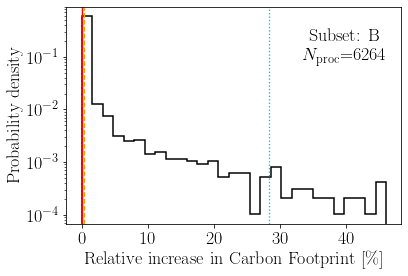

C
<class 'numpy.ndarray'>
-9.41348428791758e-16 242.4406365272514


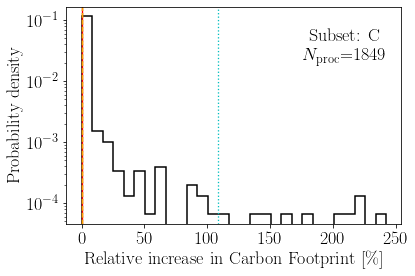

D
<class 'numpy.ndarray'>
-2.0716234146511876e-22 26.763947399450426


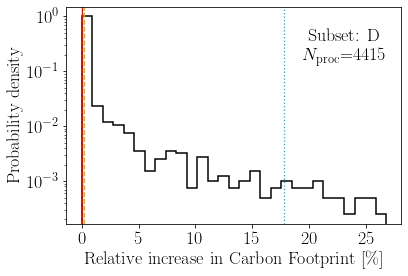

In [26]:
color = ['c', 'orange', 'r', 'orange', 'c']
linestyle = [':', '--', '-', '--', ':']

#hybrid_baci, hybrid_non_baci, hybrid all
masklist = [hybrid_process_boolean_mask, BACI_hybrid_list_booolean_mask,
            hybrid_processes_without_baci_price_boolean_mask]
mask_name = ['B', 'C' , 'D']
for j,(mask,name) in enumerate(zip(masklist, mask_name)):
    print(name)
    fig = plt.figure(j)
    ax = fig.add_subplot(111)
    lca_impact = lca_impacts[425,mask]
    dist = np.nan_to_num(np.nanmedian(impacts_io_samples[0,mask, :], axis=1)/lca_impact*100)
    # print(type(dist))
    bin_edges = np.linspace(*np.percentile(dist, [0, 98]), 30)#  np.histogram_bin_edges(dist, bins='doane')
    print(bin_edges.min(), bin_edges.max())
    ax.hist(dist, bins=bin_edges, color='k', lw=1.5, histtype='step', density=True)
    #'''
    for i,x in enumerate(np.percentile(dist, [2.5, 16, 50, 84, 97.5])):
        ax.axvline(x=x, c=color[i], ls=linestyle[i], lw=1.3)
    #ax.axvline(x=dist.mean(), color='r', ls='-.', lw=1.3)
    #ax.axvline(x=impacts_io_price_from_pylcaio[4,mask].sum()/lca_impact*100, color='k', ls='--', lw=1.3)
    
    ax.text(0.83, 0.9, s='Subset: {} '.format(name), 
            horizontalalignment='center', verticalalignment='top', 
            transform=ax.transAxes)
    ax.text(0.83, 0.8, s='$N_\mathrm{{proc}}$={}'.format(sum(mask)), 
            horizontalalignment='center', verticalalignment='top', 
            transform=ax.transAxes)
    
    ax.set_xlabel(r'Relative increase in Carbon Footprint [\%]')
    ax.set_ylabel(r'Probability density')
    #'''
    ax.set_yscale('log')
    plt.show()